In [11]:
from stage1 import *

In [12]:
nframes,natoms,nmols=(0,0,0)

In [13]:
from stage2 import *

In [14]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [15]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [16]:
cf=condenseframe(testframe)

In [17]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::100]

50001 4 592


In [18]:
cf

array([[-0.85698723,  1.23109918, -0.27008201,  2.28225017,  0.95225006,
         1.95350003],
       [-0.84197716,  1.22660766, -0.24687831,  1.36549997,  1.45650005,
         2.59900022],
       [-1.05650566,  0.13300078, -1.2022397 ,  0.83375001,  1.77175009,
         0.73750007],
       ...,
       [-0.85929233,  1.17163535, -0.3106447 ,  2.56474996,  1.57500005,
         2.47574997],
       [-0.85346744,  1.15585031, -0.31337054,  1.61825013,  1.92200017,
         2.49900007],
       [-1.04945438,  0.24970716, -1.11867726,  0.79150009,  2.24175   ,
         2.16525006]])

In [19]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 501/501 [00:16<00:00, 30.19it/s]

296592


In [20]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [21]:
g = get_graph(cf,1,n_neigh,"cry")

In [22]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [31]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 2
lr = 1e-4
n_epochs = 200
batch_size=512
test_train_split = 0.8
model_name = "model2.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [32]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 296592/296592 [00:02<00:00, 133995.98it/s]


In [33]:
graphs = graphs_device
total_graphs = len(graphs)


In [34]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cpu
total_graphs: 296592
batch Size: 512
number of batches: 579
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 2, bias=True)
    (mu): Linear(2, 2, bias=True)
    (logstd): Linear(2, 2, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(2, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [35]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [36]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [37]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [38]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 50.4239
	Test: 	MSE Loss: 26.4722
Epoch: 002
	Train:	MSE Loss: 22.6045
	Test: 	MSE Loss: 24.3149
Epoch: 003
	Train:	MSE Loss: 21.1531
	Test: 	MSE Loss: 23.4567
Epoch: 004
	Train:	MSE Loss: 20.7138
	Test: 	MSE Loss: 22.8165
Epoch: 005
	Train:	MSE Loss: 20.3707
	Test: 	MSE Loss: 21.9833
Epoch: 006
	Train:	MSE Loss: 20.0370
	Test: 	MSE Loss: 21.3632
Epoch: 007
	Train:	MSE Loss: 19.3824
	Test: 	MSE Loss: 20.6585
Epoch: 008
	Train:	MSE Loss: 18.4604
	Test: 	MSE Loss: 20.2219
Epoch: 009
	Train:	MSE Loss: 17.4697
	Test: 	MSE Loss: 19.7086
Epoch: 010
	Train:	MSE Loss: 16.2744
	Test: 	MSE Loss: 18.5860
Epoch: 011
	Train:	MSE Loss: 15.7179
	Test: 	MSE Loss: 17.5371
Epoch: 012
	Train:	MSE Loss: 15.0437
	Test: 	MSE Loss: 17.2414
Epoch: 013
	Train:	MSE Loss: 14.7417
	Test: 	MSE Loss: 16.5360
Epoch: 014
	Train:	MSE Loss: 14.4102
	Test: 	MSE Loss: 16.4189
Epoch: 015
	Train:	MSE Loss: 14.1780
	Test: 	MSE Loss: 15.7130
Epoch: 016
	Train:	MSE Loss: 14.0514
	Test: 	MSE Loss: 

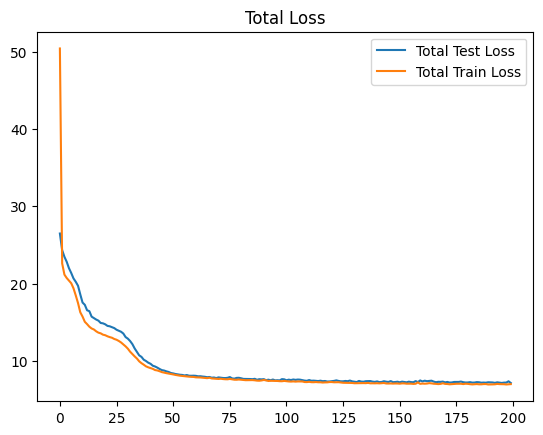

In [39]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.savefig("model2.pt_total_loss.png")
    plt.show()

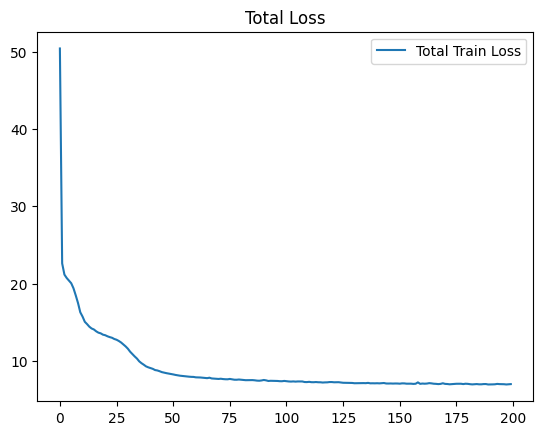

In [40]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

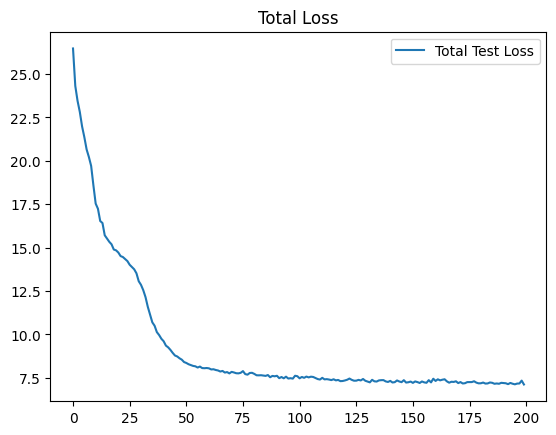

In [41]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [42]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()
    Error_total = F.mse_loss(decoded_x, test_graph.x).detach().cpu().numpy()


    avg1 += Error_wo_s
    avg2+= Error_total

print("Average Error", avg1/len(test_loader))
print("Average Error", avg2/len(test_loader))


Average Error 7.12007844759159
Average Error 7.2078708151549185


In [43]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[1][heavy_indices])

21

In [44]:
input_feature[1]

tensor([[-1.3854e+00, -2.9479e-01, -1.9132e+00,  6.4500e-01,  1.9705e+01,
          8.3125e+00],
        [-9.8570e-01,  1.0220e+00, -5.6420e-01,  1.4900e+00,  1.7938e+01,
          6.6125e+00],
        [-1.4378e+00,  5.6948e-02, -1.7711e+00,  3.7875e+00,  1.9780e+01,
          7.8875e+00],
        [-7.0000e-01,  1.0333e+00, -1.9664e-01,  2.6575e+00,  1.6802e+01,
          8.6425e+00],
        [-1.5031e+00,  1.2455e-01, -1.8111e+00,  2.9700e+00,  1.9198e+01,
          1.1305e+01],
        [-1.0609e+00,  1.1268e+00, -5.8838e-01,  1.7800e+00,  2.3575e+01,
          6.5350e+00],
        [-1.0003e+00,  5.1016e-01, -8.9205e-01,  2.2075e+00,  2.0395e+01,
          4.2425e+00],
        [-1.1053e+00,  1.2848e+00, -5.5818e-01,  4.0350e+00,  2.2310e+01,
          9.7050e+00],
        [-1.1779e+00,  1.6494e+00, -4.2448e-01,  5.1500e-01,  1.5305e+01,
          1.0788e+01],
        [-1.1391e+00,  1.2608e+00, -6.0699e-01,  3.7100e+00,  1.7972e+01,
          4.6850e+00],
        [-1.2104e+00, -1.6770e

In [45]:
input_feature[20][heavy_indices]

tensor([[-1.3732e+00, -2.3288e-03, -1.7141e+00,  1.3995e+01,  1.5720e+01,
          1.2208e+01],
        [-1.1495e+00, -1.0140e-01, -1.4743e+00,  1.5012e+01,  1.3710e+01,
          1.3380e+01],
        [-8.8462e-01,  2.8560e-01, -8.8911e-01,  1.1440e+01,  1.5990e+01,
          1.3118e+01],
        [-1.7205e+00,  7.4045e-01, -1.7273e+00,  1.6347e+01,  1.5123e+01,
          1.0805e+01],
        [-8.7133e-01,  3.9795e-01, -8.2021e-01,  1.3163e+01,  1.7853e+01,
          1.4285e+01],
        [-9.3510e-01,  1.2519e+00, -3.5908e-01,  1.2823e+01,  1.6258e+01,
          9.1175e+00],
        [-1.3202e+00,  1.1186e+00, -9.4530e-01,  1.5755e+01,  1.7880e+01,
          1.0038e+01],
        [-1.2995e+00, -8.7216e-02, -1.6647e+00,  1.1040e+01,  1.3485e+01,
          1.3910e+01],
        [-1.2373e+00,  1.1990e+00, -7.8090e-01,  1.7125e+01,  1.4360e+01,
          1.4748e+01],
        [-9.7827e-01,  7.9199e-01, -6.9306e-01,  1.0998e+01,  1.4383e+01,
          9.1075e+00],
        [-1.3199e+00,  2.9809e

In [46]:
decoded_feature[20][heavy_indices]

tensor([[-1.0567,  0.7031, -0.8765, 20.5210, 21.1405,  6.5080],
        [-1.2765,  0.7795, -1.0827, 20.1460, 20.6513,  6.8407],
        [-1.2765,  0.7795, -1.0827, 20.1452, 20.6522,  6.8405],
        [-1.2766,  0.7795, -1.0828, 20.1286, 20.6722,  6.8376],
        [-1.2766,  0.7795, -1.0828, 20.1378, 20.6613,  6.8392],
        [-1.2767,  0.7795, -1.0829, 20.1176, 20.6816,  6.8360],
        [-1.2768,  0.7797, -1.0830, 20.0775, 20.7134,  6.8303],
        [-1.2766,  0.7795, -1.0828, 20.1353, 20.6645,  6.8387],
        [-1.2764,  0.7795, -1.0826, 20.1584, 20.6360,  6.8429],
        [-1.2765,  0.7795, -1.0827, 20.1466, 20.6506,  6.8408],
        [-1.2765,  0.7795, -1.0827, 20.1420, 20.6561,  6.8400],
        [-1.2767,  0.7795, -1.0829, 20.1165, 20.6825,  6.8359],
        [-1.2768,  0.7797, -1.0830, 20.0740, 20.7162,  6.8298],
        [-1.2768,  0.7797, -1.0830, 20.0777, 20.7132,  6.8304],
        [-1.2766,  0.7795, -1.0828, 20.1335, 20.6666,  6.8384],
        [-1.2767,  0.7796, -1.0829, 20.1

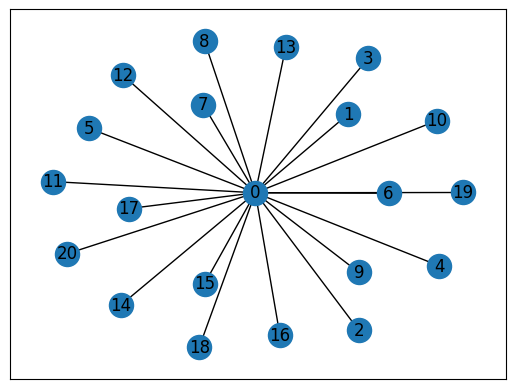

In [47]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [48]:
def plotCompare(features1,features2):
    # %matplotlib widget
    xyz1 = features1[:,-3:]
    xyz2 = features2[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="output")
    ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="input")
    plt.legend()
    plt.show()

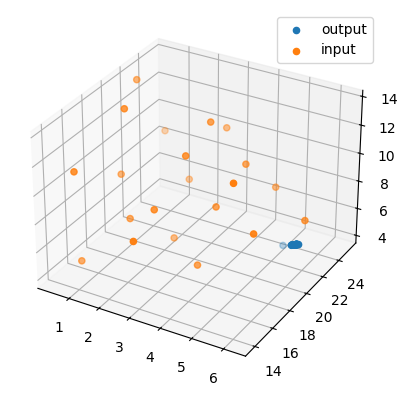

In [49]:
plotCompare(decoded_feature[1].detach().numpy(),input_feature[1].detach().numpy())


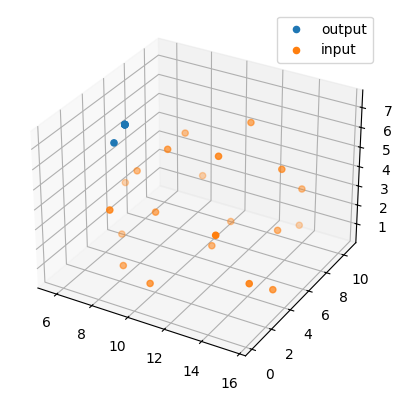

In [50]:
plotCompare(decoded_feature[15].detach().numpy(),input_feature[15].detach().numpy())

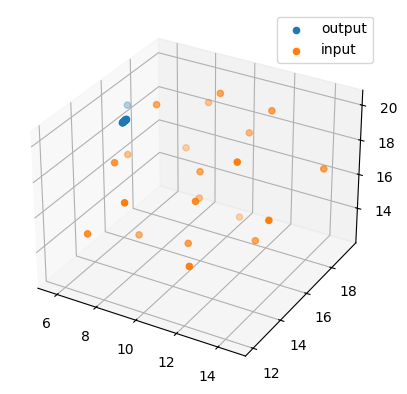

In [51]:
plotCompare(decoded_feature[39].detach().numpy(),input_feature[39].detach().numpy())